In [27]:
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pylab as plt
import seaborn as sns

from tqdm import tqdm

import contractions
import nltk
from nltk.corpus import stopwords, wordnet
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('averaged_perceptron_tagger')

from collections import defaultdict, Counter

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fashaikh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\fashaikh\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
plt.rcParams['figure.figsize'] = [18, 15]
plt.style.use('fivethirtyeight')

In [3]:
sns.set(rc={'figure.figsize':(18, 15)})
sns.set_theme(style="darkgrid")

In [4]:
df_copy = pd.read_parquet(r"C:\Users\fashaikh\Desktop\Thesis_main\combined_emotion_sentiment.parquet")

In [7]:
df.head()

,id,cleanedContent,label,category,emotion_label
0,1257990410028359681,Everyday that the killers of #AhmaudArbery rem...,negative,African American South,fear
1,1258706164054929408,It took 59 days for the @user to arrest #Grego...,negative,African American South,disgust
2,1258706164054929408,It took 59 days for the @user to arrest #Grego...,negative,African American South,disgust
3,1258706164054929408,It took 59 days for the @user to arrest #Grego...,negative,African American South,disgust
4,1258706164054929408,It took 59 days for the @user to arrest #Grego...,negative,African American South,disgust


In [8]:
df_copy = df.copy()

In [5]:
df_copy = df_copy[['cleanedContent', 'label', 'emotion_label', 'category']]

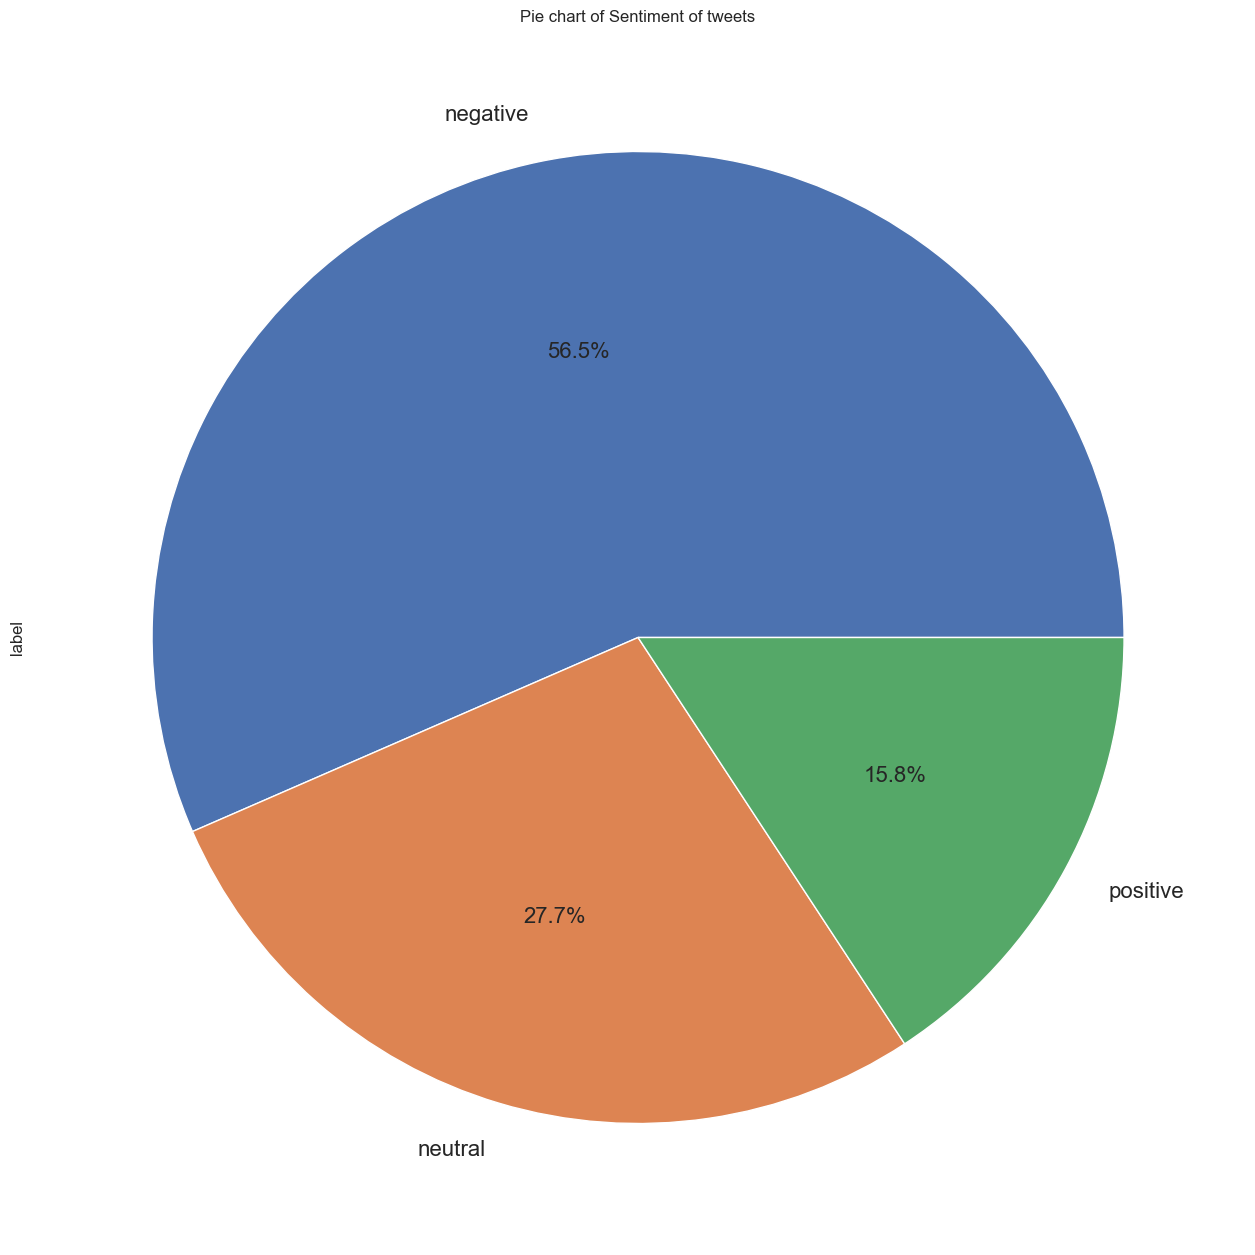

In [23]:
df['label'].value_counts().plot(kind='pie',
                                         title='Pie chart of Sentiment of tweets', 
                                         autopct='%1.1f%%',
                                         shadow=False,
                                         legend = False, fontsize=16, figsize=(15,15))
plt.show()

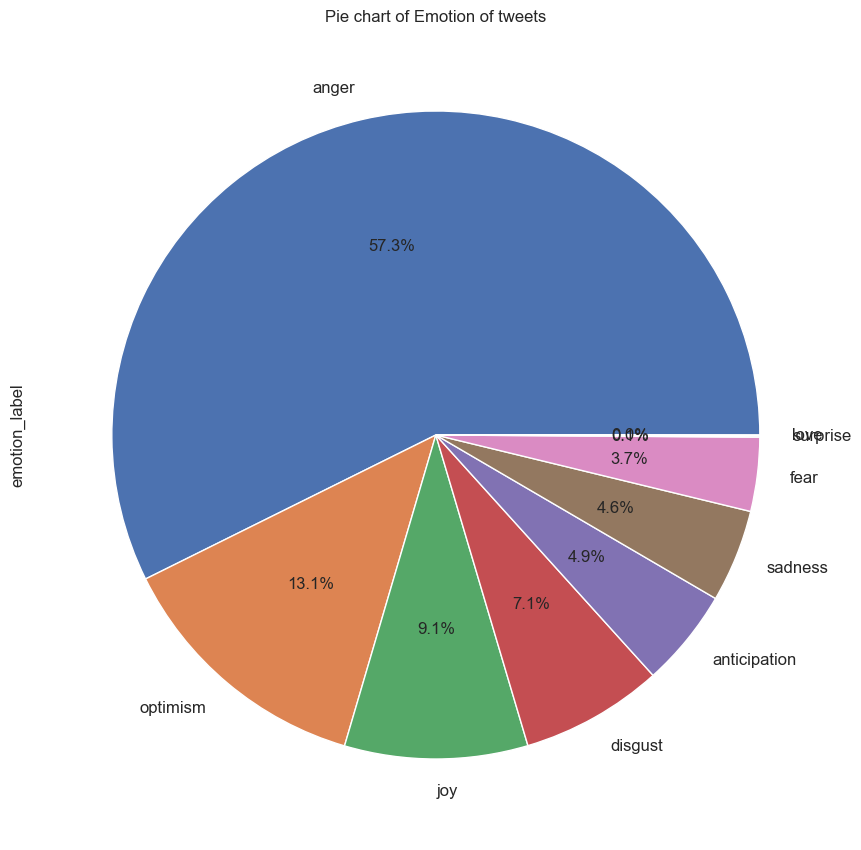

In [21]:
df['emotion_label'].value_counts().plot(kind='pie',
                                         title='Pie chart of Emotion of tweets', 
                                         autopct='%1.1f%%',
                                         shadow=False,
                                         legend = False, fontsize=12, figsize=(10,10))
plt.show()

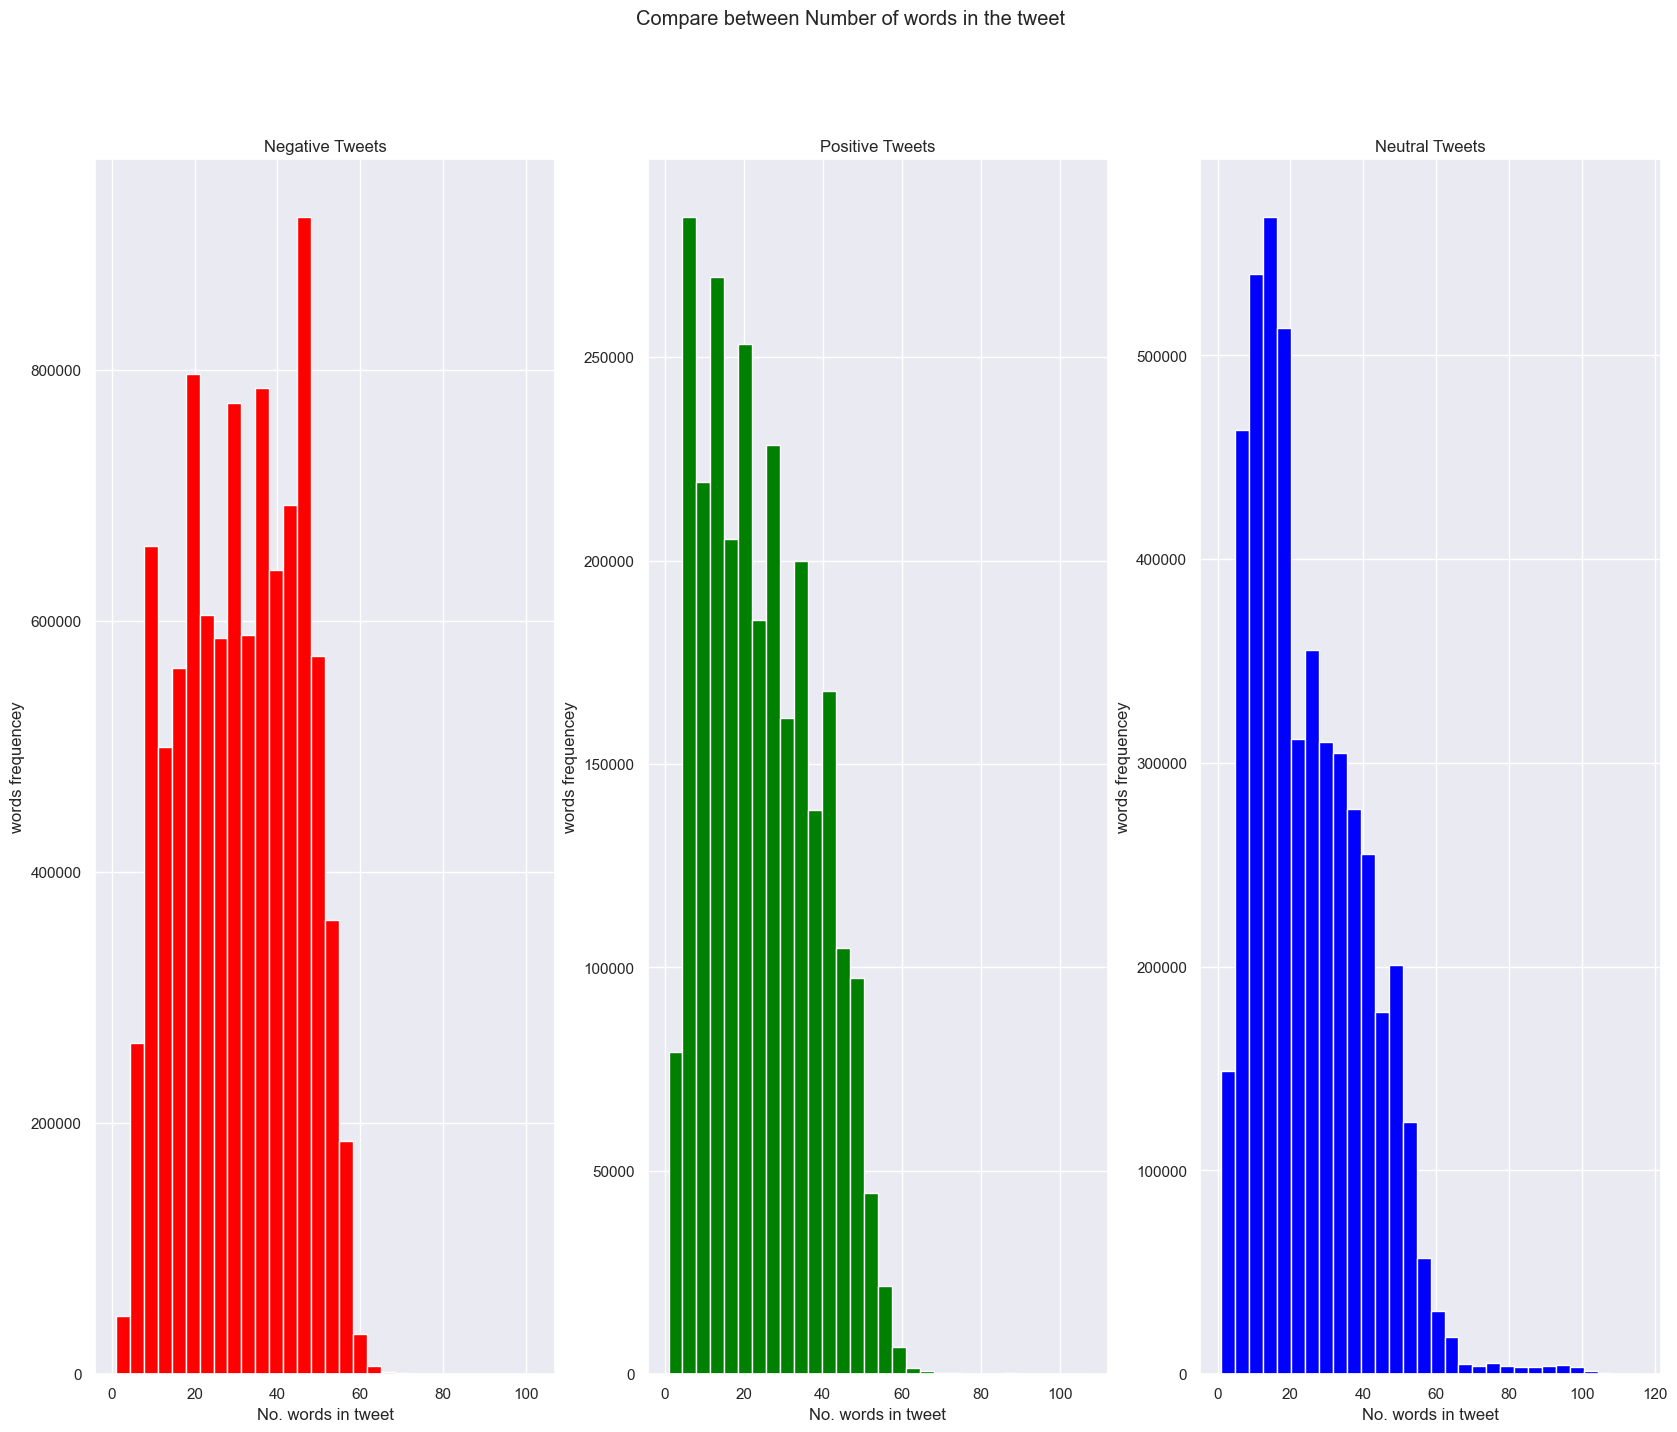

In [24]:
sns.set(style='darkgrid')
fig, axes = plt.subplots(1, 3)
fig.suptitle('Compare between Number of words in the tweet')

axes[0].hist(df[df['label'] == "negative"]['cleanedContent'].str.split().map(lambda word: len(word)),
             bins=30, color='red')
axes[0].set_ylabel('words frequencey')
axes[0].set_xlabel('No. words in tweet')
axes[0].set_title('Negative Tweets')


axes[1].hist(df[df['label'] == "positive"]['cleanedContent'].str.split().map(lambda word: len(word)),
             bins=30, color='green', label='Disaster')
axes[1].set_ylabel('words frequencey')
axes[1].set_xlabel('No. words in tweet')
axes[1].set_title('Positive Tweets')

axes[2].hist(df[df['label'] == "neutral"]['cleanedContent'].str.split().map(lambda word: len(word)),
             bins=30, color='blue', label='Disaster')
axes[2].set_ylabel('words frequencey')
axes[2].set_xlabel('No. words in tweet')
axes[2].set_title('Neutral Tweets')

plt.show()

### Clean Tweet

In [5]:
def clean_tweet(text):
    # Remove mentions
    text = re.sub(r"@user", "", text)

    # Remove URLs
    text = re.sub(r"http", "", text)

    # Remove extra whitespaces
    text = re.sub(r"\s+", " ", text).strip()

    # Remove leading whitespaces
    text = re.sub(r"^\s+","",text)

    # Replace &amp; with and
    text = re.sub(r"&amp;","and",text)

    return text

def parse_hashtags(text):
    hashtag=re.compile(r'(\#)(\w+)(_)(\w+)', re.IGNORECASE)
    text = hashtag.sub(r'\2 \4',text)
    return text.replace('_', ' ')

In [6]:
df_copy['text'] = df_copy['cleanedContent'].apply(lambda sentence: parse_hashtags(sentence))

In [7]:
df_copy['text'] = df_copy['text'].apply(clean_tweet)

In [8]:
def en_contractions(text):
    return ' '.join([contractions.fix(word) if word in contractions.contractions_dict else word for word in text.split()])

In [9]:
df_copy['text'] = df_copy['text'].apply(lambda sentence: en_contractions(sentence))

In [10]:
s_chars = '¥₽ÏïŰŬĎŸæ₿₪ÚŇÀèÅ”ĜåŽÖéříÿý€ŝĤ₹áŜŮÂ₴ûÌÇšŘúüëÓ₫ŠčÎŤÆÒœ₩öËäøÍťìĈôàĥÝ¢ç“žðÙÊĉŭÈŒÐÉÔĵùÁů„âÄűĴóêĝÞîØòď฿ČÜþňÛ'
PUNC = '.+@«#_\-!$%%^&*¬()£<>?/\\|}\]\[{;\,~:\"\''

In [11]:
def special_char(text):
    # first, let's remove any unicode strings
    text = text.encode('ascii', 'ignore').decode()
    # remove printable bachslashes
    text = re.sub(r'[\t\s\n\r\b\a]', ' ', text)
    # Special letters
    text = re.sub(r'[{}]'.format(s_chars), '', text)
    # Punctuation
    text = re.sub(r'[{}]'.format(PUNC), ' ', text)
    # space at the start or the end of the context
    text = re.sub(r'(^\s)|(\s$)', '', text)
    # Single character
    text = re.sub(r'(\s[^iIaA]\s)', ' ', text)
    return text

In [12]:
df_copy['text'] = df_copy['text'].apply(lambda sentence: special_char(sentence))

In [13]:
df_copy['text'] = df_copy['text'].str.replace('\d+', '', regex=True)

### Stopwords cleaning

In [14]:
SWs = stopwords.words('english')

In [15]:
df_copy['text'] = df_copy['text'].str.lower()

In [16]:
def remove_stopwords(text):
    return " ".join([word for word in text.split() if word not in SWs])

In [18]:
df_copy['text_without_stopwords'] = df_copy['text'].apply(lambda sentence: remove_stopwords(sentence))

In [19]:
lemmatizer = WordNetLemmatizer()
wordnet_map = {'N': wordnet.NOUN, 'V': wordnet.VERB, 'J': wordnet.ADJ, 'R': wordnet.ADJ}

In [28]:
def adjusted_lemmatizer(text):
    # Split the snetence into words and each word with its type
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

In [170]:
df_copy['text_lemmatized'] = df_copy['text_lemmatized'].str.replace(r"(\s[^iIaA]\s)", ' ', regex=True)
df_copy['text_lemmatized'] = df_copy['text_lemmatized'].str.replace(r'\s(\w$)|\s(\w[^me]$)', '', regex=True)
df_copy['text_lemmatized'] = df_copy['text_lemmatized'].str.replace(r'\s ', ' ', regex=True)
df_copy['text_lemmatized'] = df_copy['text_lemmatized'].str.replace(r'(^\s)|(\s$)', '', regex=True)

In [171]:
len(df_copy['text_lemmatized'].loc[
    df_copy['text_lemmatized'].str.contains(r"(\s[^iIaA]\s)")])

C:\Users\fashaikh\AppData\Local\Temp\ipykernel_12456\2997698581.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_copy['text_lemmatized'].str.contains(r"(\s[^iIaA]\s)")])


53

In [172]:
def plot_words_freq(dataframe: pd.DataFrame,
                    column,
                    target_label, axes):
    words_dict = {'word': [], 'count': []}
    words_count = Counter(
        ' '.join(dataframe[[column,'label']]\
                 .loc[dataframe['label'] == target_label]\
                 [column]).split()).most_common(100)
    
    for word, count in words_count:
        words_dict['word'].append(word)
        words_dict['count'].append(count)
    
    sns.barplot(x=words_dict['count'][:20], y=words_dict['word'][:20], ax=axes)
    axes.set_yticks(range(20), words_dict['word'][:20], size=16)

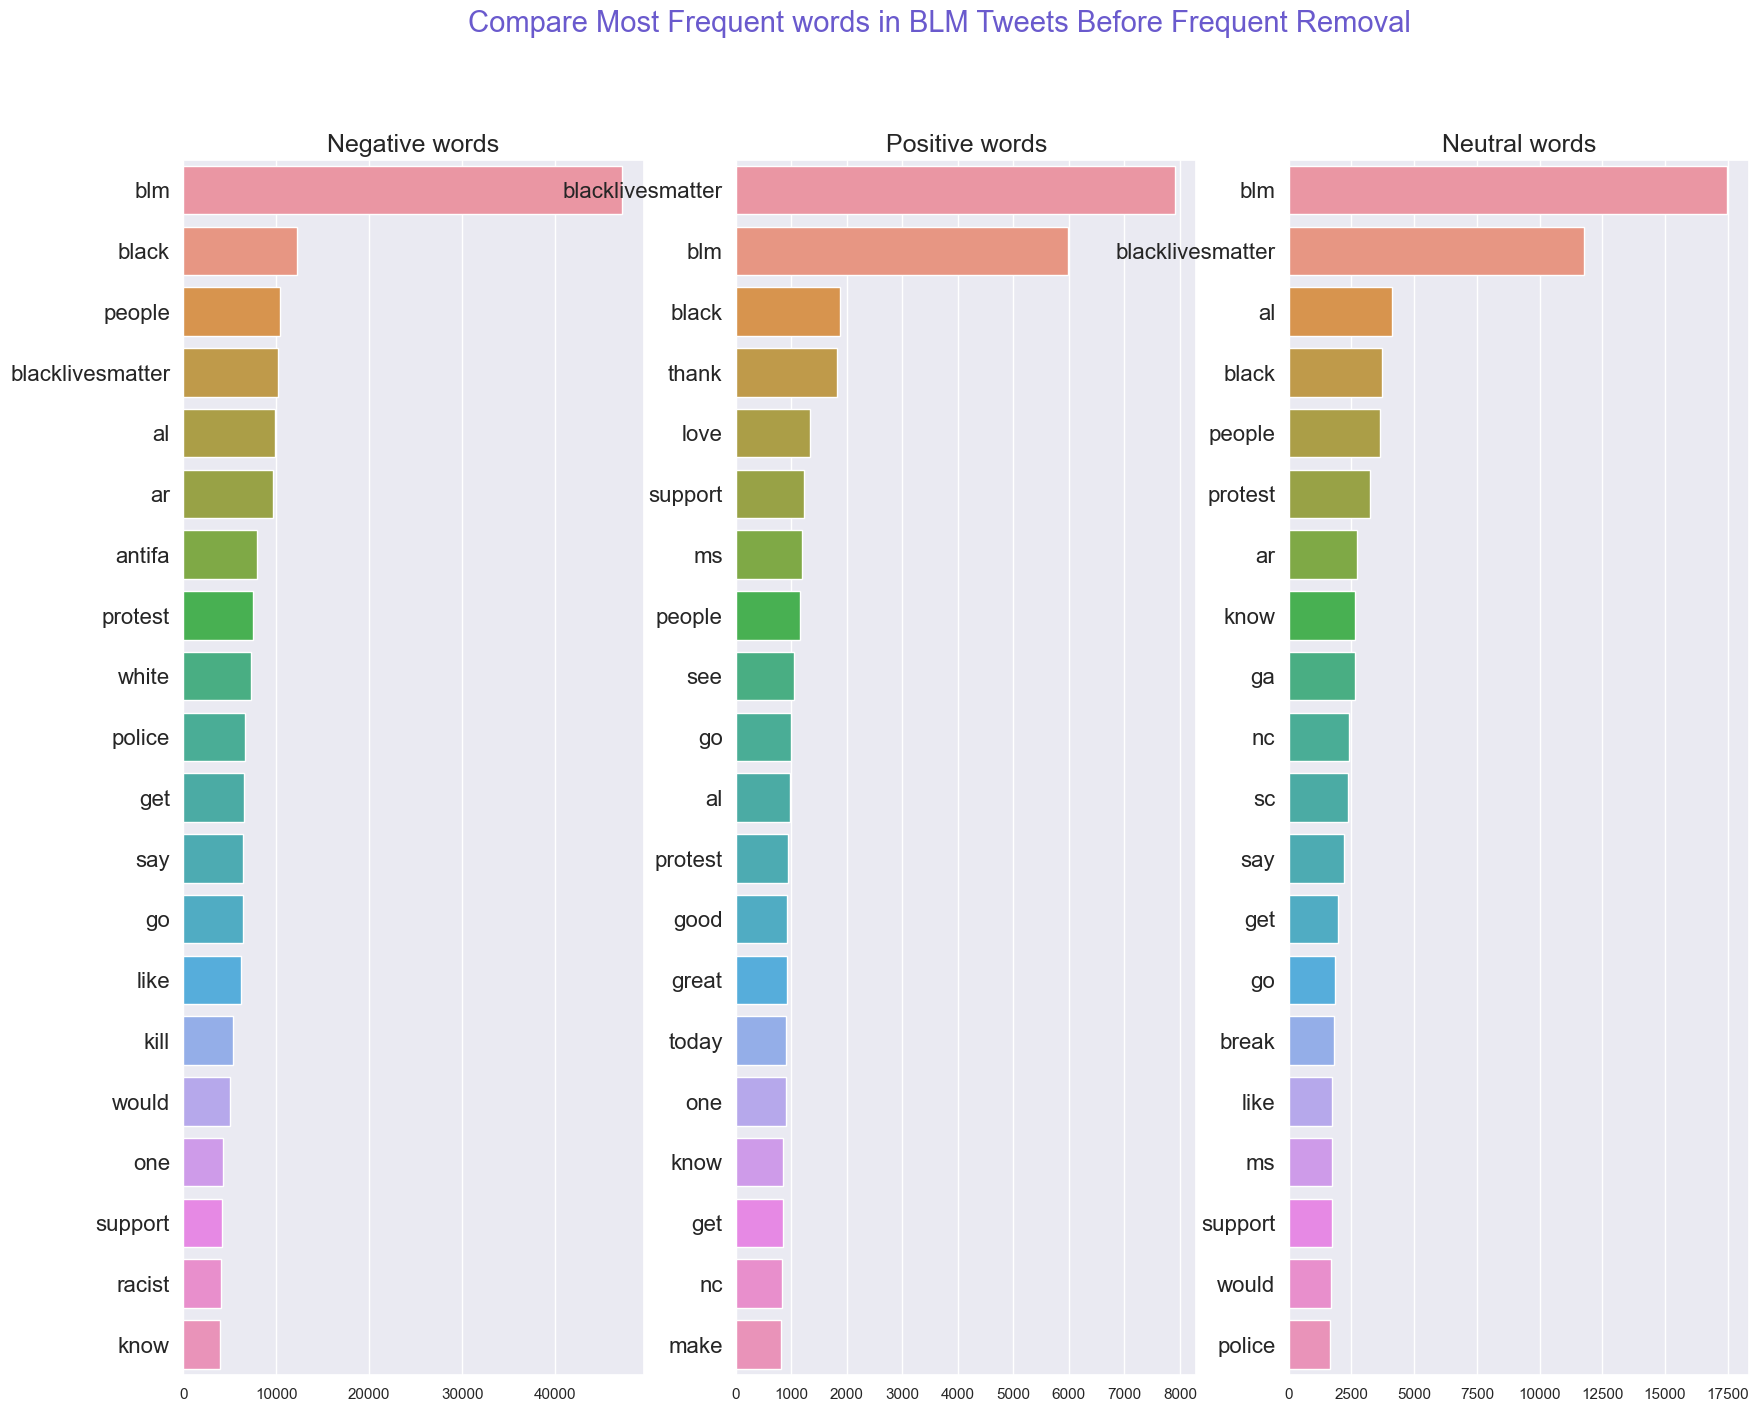

In [173]:
fig, axes = plt.subplots(1, 3)

fig.suptitle('Compare Most Frequent words in BLM Tweets Before Frequent Removal',
             size=21, color='SlateBlue')
axes[0].set_title('Negative words', size=18)
axes[1].set_title('Positive words', size=18)
axes[2].set_title('Neutral words', size=18)

plot_words_freq(df_copy, 'text_lemmatized', target_label="negative", axes=axes[0])
plot_words_freq(df_copy, 'text_lemmatized', target_label="positive", axes=axes[1])
plot_words_freq(df_copy, 'text_lemmatized', target_label="neutral", axes=axes[2])
plt.show()

In [174]:
NEGATIVE_WORDS = ['blm', 'black', 'blacklivesmatter', 'antifa', 'white', 'protest', 'police', 'kill', 'support', 'trump', 'racist']
POSITIVE_WORDS = ['thank', 'love', 'great', 'good', 'like']

In [175]:
def words_counter_removal(dataframe: pd.DataFrame,
                          column,
                          frequency,
                          ascending: False):
    """
    | Select the topest/lowest frequent words to in a set.
    Args:
        dataframe[pd.DataFrame]: dataframe you're going to select the frequent words from.
        column[Text]: column you're going to select the frequent words from.
        frequency[int]: the number of words you're going to select from the list of tuples.
        ascending[Optional[bool]]: whether ascending | descending. (default: False)
    Returns:
        Set[Text]
    """
    counter = Counter()
    for tweet in dataframe[column].values:
        for word in tweet.split():
            counter[word] += 1
    
    # Words should not be detected
    for word in NEGATIVE_WORDS + POSITIVE_WORDS:
        counter.pop(word)
    
    if not ascending:
        return set([word for (word, counts) in counter.most_common(frequency)])
    else:
        return set([word for (word, counts) in counter.most_common()[:-frequency-1:-1]])

In [176]:
FREQ_WORDS = words_counter_removal(df_copy, 'text_lemmatized', 20, False)

In [177]:
def remove_freqwords(text,
                     freq_words):
    """custom function to remove the frequent words"""
    return " ".join([word for word in str(text).split() if word not in freq_words])

In [178]:
df_copy['text_without_stopwords_freq'] = df_copy['text_lemmatized'].apply(lambda text: remove_freqwords(text, FREQ_WORDS))

In [136]:
df_copy.head()

,date,id,cleanedContent,label,text,text_without_stopwords,text_lemmatized,text_without_stopwords_freq
0,2020-05-06 11:07:40+00:00,1257990410028359681,Everyday that the killers of #AhmaudArbery rem...,negative,everyday that the killers of ahmaudarbery rem...,everyday killers ahmaudarbery remain free anot...,everyday killer ahmaudarbery remain free anoth...,everyday killer ahmaudarbery remain free anoth...
1,2020-05-08 10:31:49+00:00,1258706164054929408,It took 59 days for the @user to arrest #Grego...,negative,it took days for the to arrest gregorymcmich...,took days arrest gregorymcmichael travismcmich...,take day arrest gregorymcmichael travismcmicha...,day arrest gregorymcmichael travismcmichael mu...
2,2020-05-08 10:31:49+00:00,1258706164054929408,It took 59 days for the @user to arrest #Grego...,negative,it took days for the to arrest gregorymcmich...,took days arrest gregorymcmichael travismcmich...,take day arrest gregorymcmichael travismcmicha...,day arrest gregorymcmichael travismcmichael mu...
3,2020-05-08 10:31:49+00:00,1258706164054929408,It took 59 days for the @user to arrest #Grego...,negative,it took days for the to arrest gregorymcmich...,took days arrest gregorymcmichael travismcmich...,take day arrest gregorymcmichael travismcmicha...,day arrest gregorymcmichael travismcmichael mu...
4,2020-05-08 10:31:49+00:00,1258706164054929408,It took 59 days for the @user to arrest #Grego...,negative,it took days for the to arrest gregorymcmich...,took days arrest gregorymcmichael travismcmich...,take day arrest gregorymcmichael travismcmicha...,day arrest gregorymcmichael travismcmichael mu...


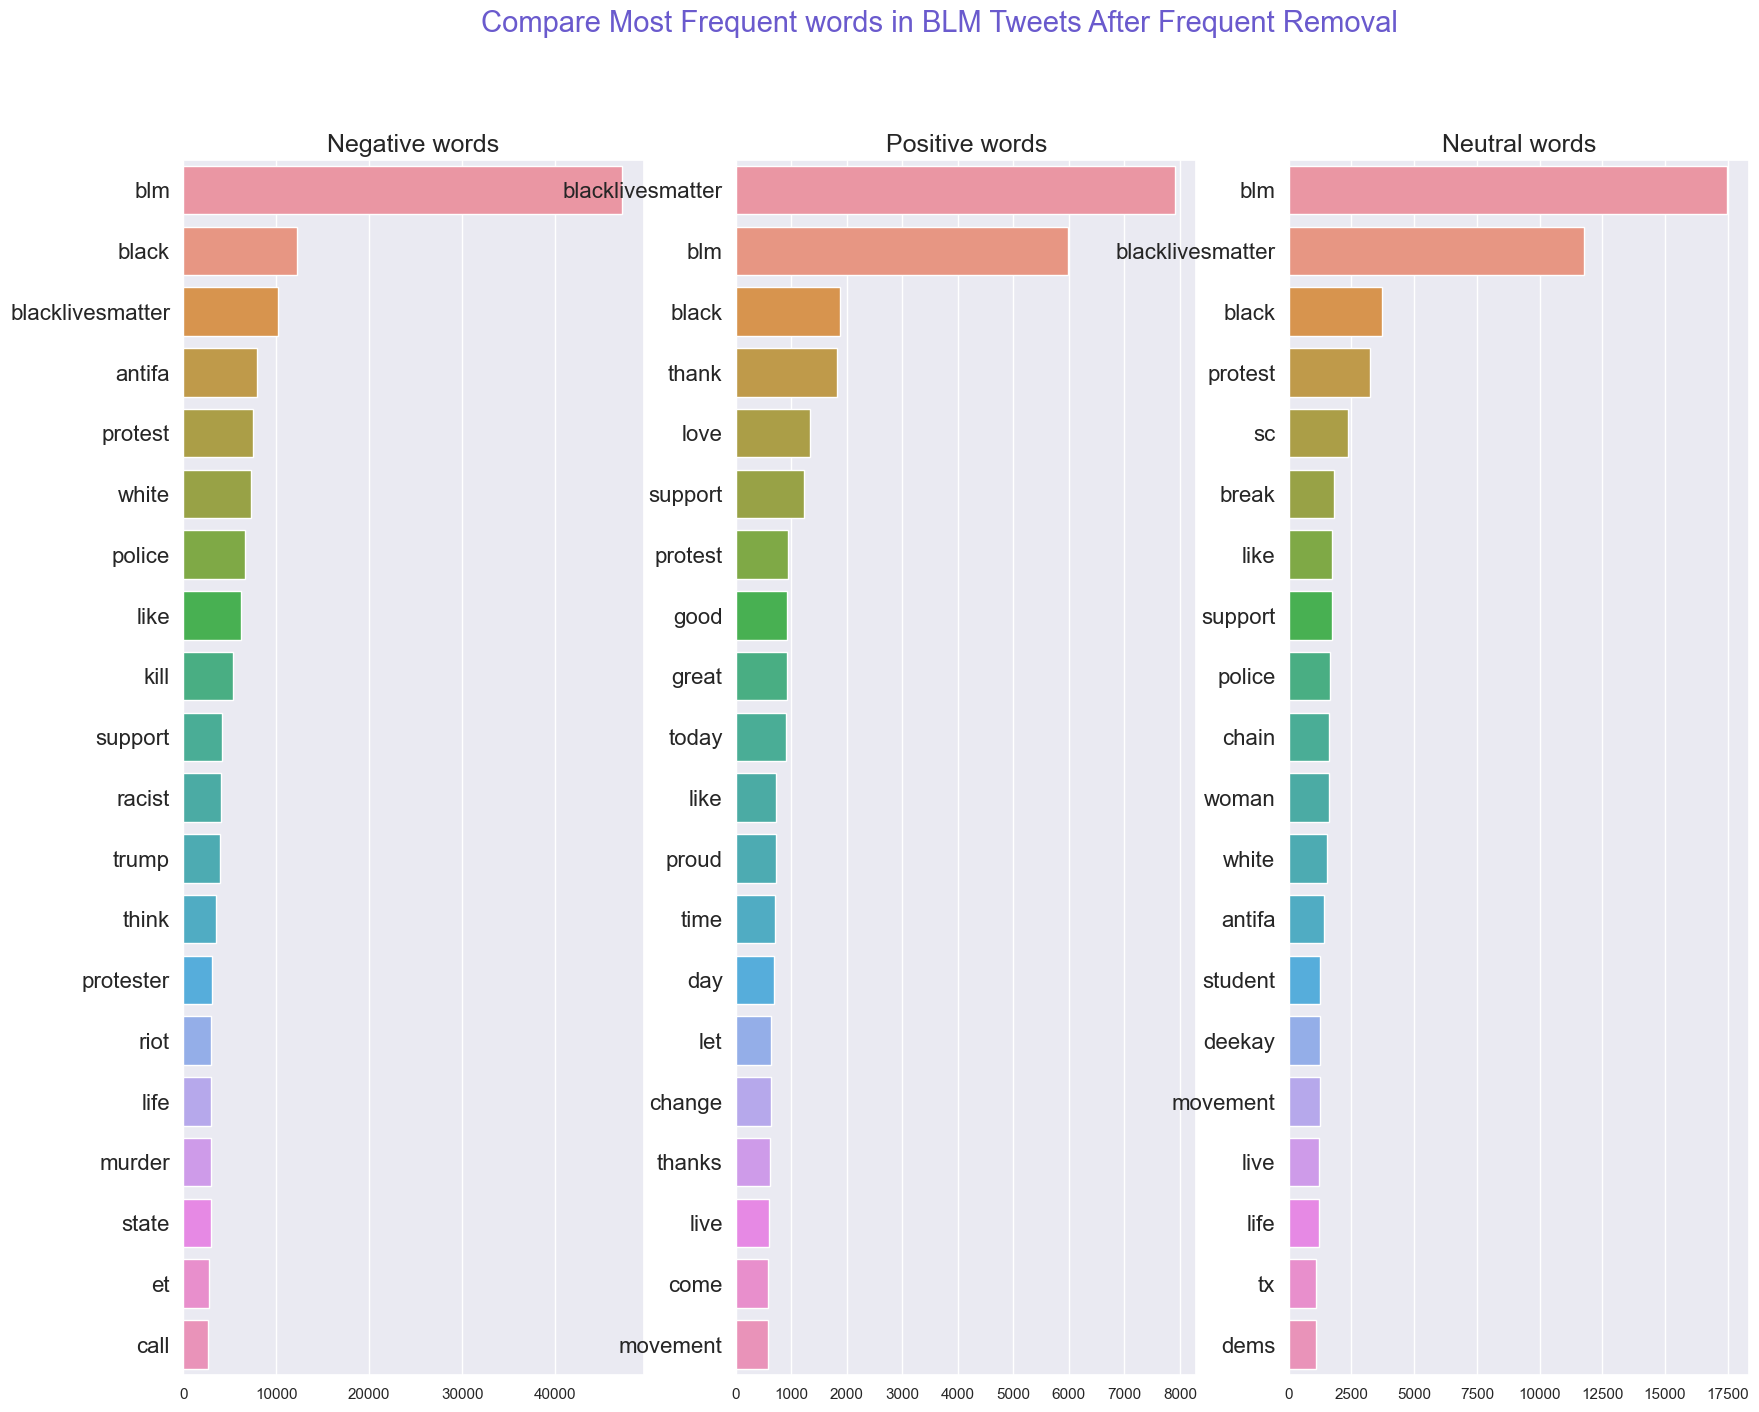

In [179]:
fig, axes = plt.subplots(1, 3)

fig.suptitle('Compare Most Frequent words in BLM Tweets After Frequent Removal',
             size=21, color='SlateBlue')
axes[0].set_title('Negative words', size=18)
axes[1].set_title('Positive words', size=18)
axes[2].set_title('Neutral words', size=18)

plot_words_freq(df_copy, 'text_without_stopwords_freq', target_label="negative", axes=axes[0])
plot_words_freq(df_copy, 'text_without_stopwords_freq', target_label="positive", axes=axes[1])
plot_words_freq(df_copy, 'text_without_stopwords_freq', target_label="neutral", axes=axes[2])
plt.show()

In [180]:
# Define the N-grams function
def gen_ngrams_fn(text, n_grams=2):
    # Split all the words and insert them into list in sequence;
    ## First, ensure that the word is not a `space`.
    ## Second, the word you're going to insert not inside the stopwords.
    word_list = [word for word in text.lower().split() 
                 if word != ' ']
    
    # capture N-sequence of words togther
    ngrams = zip(*[word_list[i:] for i in range(n_grams)])
    
    # Convert the context from list to str
    return [' '.join(ngram) for ngram in ngrams]

In [181]:
# Building the default dict that contains default int type
bigram = defaultdict(int)

# Select a tweet from the train_data where label is (`disaster`: 1, `non-disaster`: 0)
for tweet in df_copy[['text_without_stopwords_freq', 'label']][df_copy['label'] == "negative"]['text_without_stopwords_freq']:
    # Select each context and add the counter of times it found.
    for context in gen_ngrams_fn(tweet, n_grams=2):
        bigram[context] += 1

In [182]:
def ngrams_fn(dataframe,
              target_label,
              n_grams=2,
              sort=True):
    
    n_grams_dict = defaultdict(int)
    
    for tweet in dataframe[['text_without_stopwords_freq', 'label']]\
                     .loc[dataframe['label'] == target_label]['text_without_stopwords_freq']:
        for context in gen_ngrams_fn(tweet, n_grams):
            # Apply N-grams probability of the occurrence of certain N-words in certain Sequence
            # in form of most occurrence
            n_grams_dict[context] +=1
    
    # Create dataframe with number of occurrences is the id we sort the data with.
    n_grams_dataframe = pd.DataFrame(n_grams_dict.items())
    n_grams_dataframe.columns = ['N-grams', 'occurs']

    if sort:
        n_grams_dataframe.sort_values(by='occurs', ascending=False, inplace=True)
    
    return n_grams_dataframe


def plot_ngrams(dataframe,
                axes,
                number_of_samples=20) -> None:
    # Plot the dataset
    sns.barplot(x=dataframe.iloc[:,1][:number_of_samples],
                y=dataframe.iloc[:,0][:number_of_samples], ax=axes)
    axes.set_yticks(range(number_of_samples),
                    dataframe.iloc[:,0][:number_of_samples], size=14)

In [183]:
ngrams_fn(df_copy, target_label='negative')

,N-grams,occurs
254,blm protest,3474
270,blm antifa,3319
444,antifa blm,3031
355,blm protester,1778
672,support blm,1411
...,...,...
115065,nutjob group,1
115083,amaze bbc,1
115084,bbc headline,1
115086,read stab,1


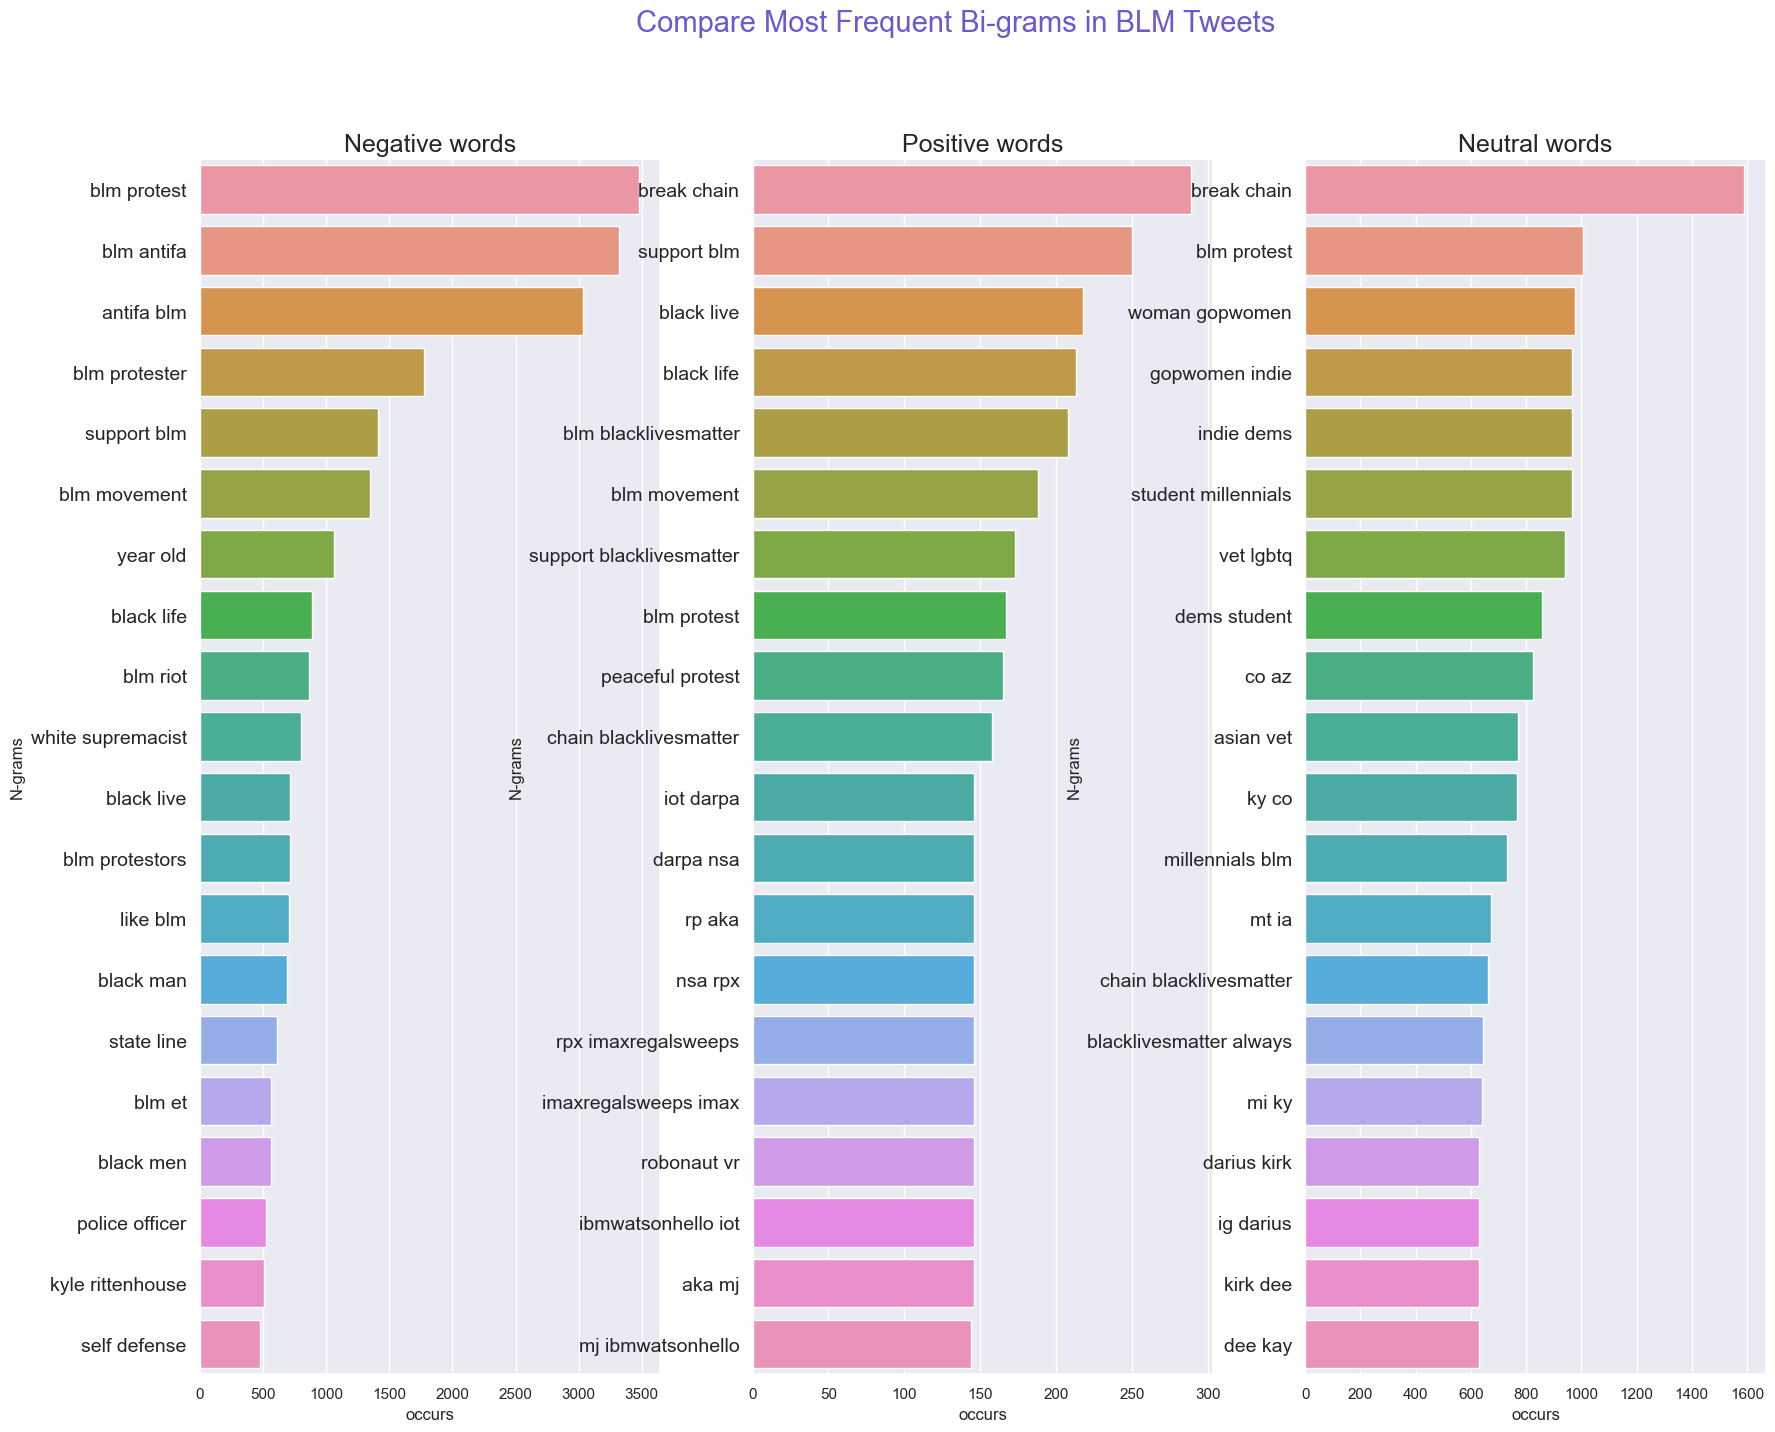

In [184]:
fig, axes = plt.subplots(1, 3)

fig.suptitle('Compare Most Frequent Bi-grams in BLM Tweets',
             size=21, color='SlateBlue')
axes[0].set_title('Negative words', size=18)
axes[1].set_title('Positive words', size=18)
axes[2].set_title('Neutral words', size=18)

plot_ngrams(ngrams_fn(df_copy, target_label='negative'), axes=axes[0])
plot_ngrams(ngrams_fn(df_copy, target_label='positive'), axes=axes[1])
plot_ngrams(ngrams_fn(df_copy, target_label='neutral'), axes=axes[2])
plt.show()

In [185]:
ngrams_fn(df_copy, target_label='negative', n_grams=2).reset_index(drop=True)\
.head(50).style.background_gradient(cmap='turbo')

,N-grams,occurs
0,blm protest,3474
1,blm antifa,3319
2,antifa blm,3031
3,blm protester,1778
4,support blm,1411
5,blm movement,1344
6,year old,1065
7,black life,886
8,blm riot,862
9,white supremacist,800


In [186]:
ngrams_fn(df_copy, target_label='positive', n_grams=2).reset_index(drop=True)\
.head(20).style.background_gradient(cmap='turbo')

,N-grams,occurs
0,break chain,289
1,support blm,250
2,black live,218
3,black life,213
4,blm blacklivesmatter,208
5,blm movement,188
6,support blacklivesmatter,173
7,blm protest,167
8,peaceful protest,165
9,chain blacklivesmatter,158


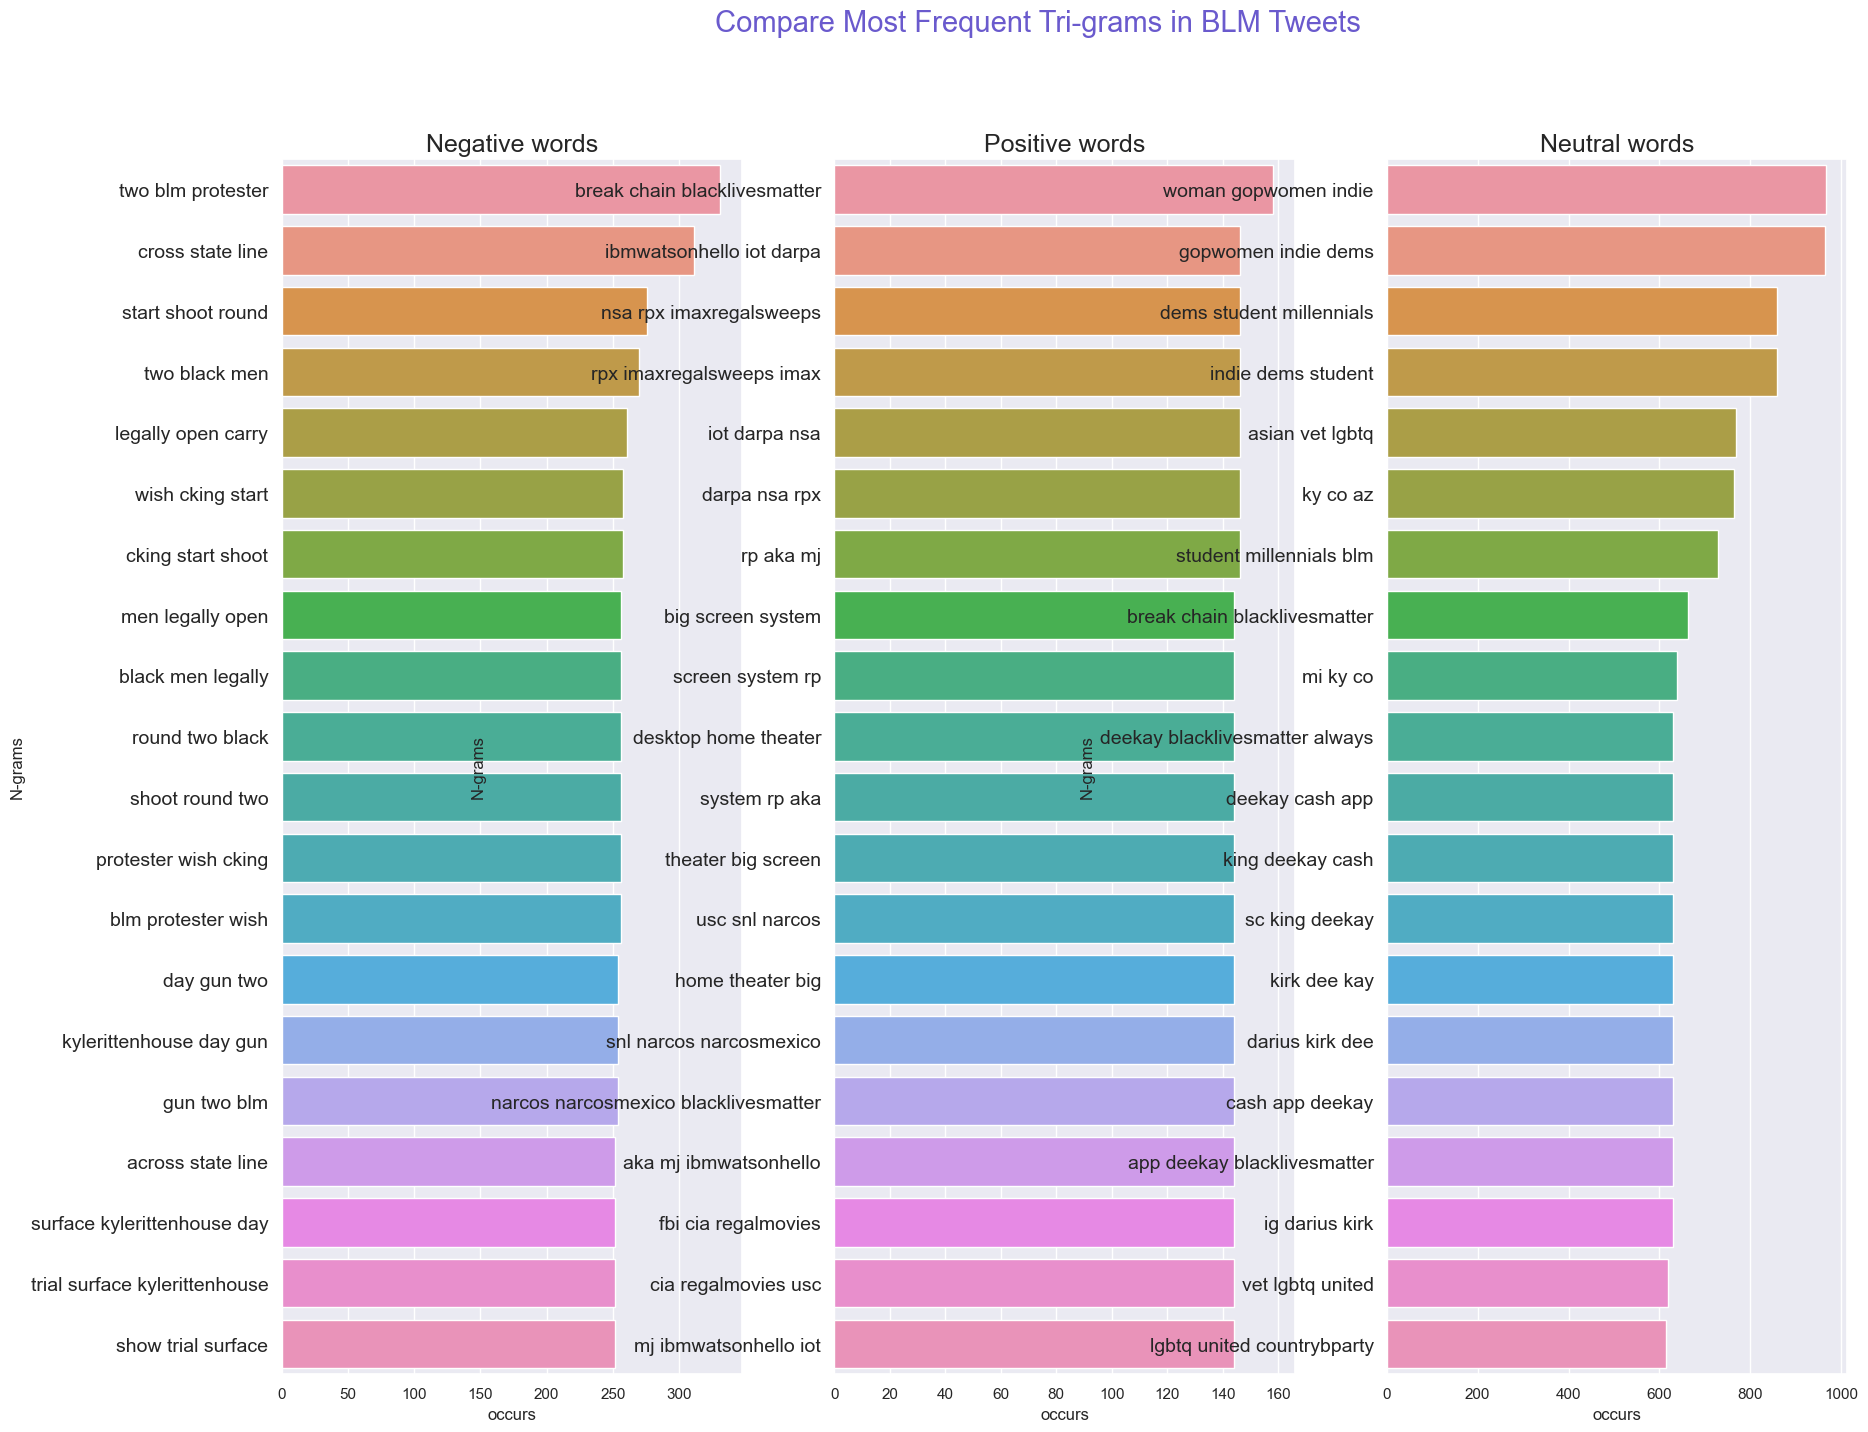

In [187]:
fig, axes = plt.subplots(1, 3)

fig.suptitle('Compare Most Frequent Tri-grams in BLM Tweets',
             size=21, color='SlateBlue')
axes[0].set_title('Negative words', size=18)
axes[1].set_title('Positive words', size=18)
axes[2].set_title('Neutral words', size=18)

plot_ngrams(ngrams_fn(df_copy, target_label='negative', n_grams=3), axes=axes[0])
plot_ngrams(ngrams_fn(df_copy, target_label='positive', n_grams=3), axes=axes[1])
plot_ngrams(ngrams_fn(df_copy, target_label='neutral', n_grams=3), axes=axes[2])
plt.show()

In [194]:
ngrams_fn(df_copy, target_label='positive', n_grams=3).reset_index(drop=True)\
.head(20).style.background_gradient(cmap='turbo')

,N-grams,occurs
0,break chain blacklivesmatter,158
1,ibmwatsonhello iot darpa,146
2,nsa rpx imaxregalsweeps,146
3,rpx imaxregalsweeps imax,146
4,iot darpa nsa,146
5,darpa nsa rpx,146
6,rp aka mj,146
7,big screen system,144
8,screen system rp,144
9,desktop home theater,144


In [195]:
ngrams_fn(df_copy, target_label='negative', n_grams=2).reset_index(drop=True)\
.head(20).style.background_gradient(cmap='turbo')

,N-grams,occurs
0,blm protest,3474
1,blm antifa,3319
2,antifa blm,3031
3,blm protester,1778
4,support blm,1411
5,blm movement,1344
6,year old,1065
7,black life,886
8,blm riot,862
9,white supremacist,800


In [196]:
ngrams_fn(df_copy, target_label='neutral', n_grams=2).reset_index(drop=True)\
.head(20).style.background_gradient(cmap='turbo')

,N-grams,occurs
0,break chain,1589
1,blm protest,1006
2,woman gopwomen,976
3,gopwomen indie,966
4,indie dems,966
5,student millennials,966
6,vet lgbtq,941
7,dems student,859
8,co az,826
9,asian vet,770


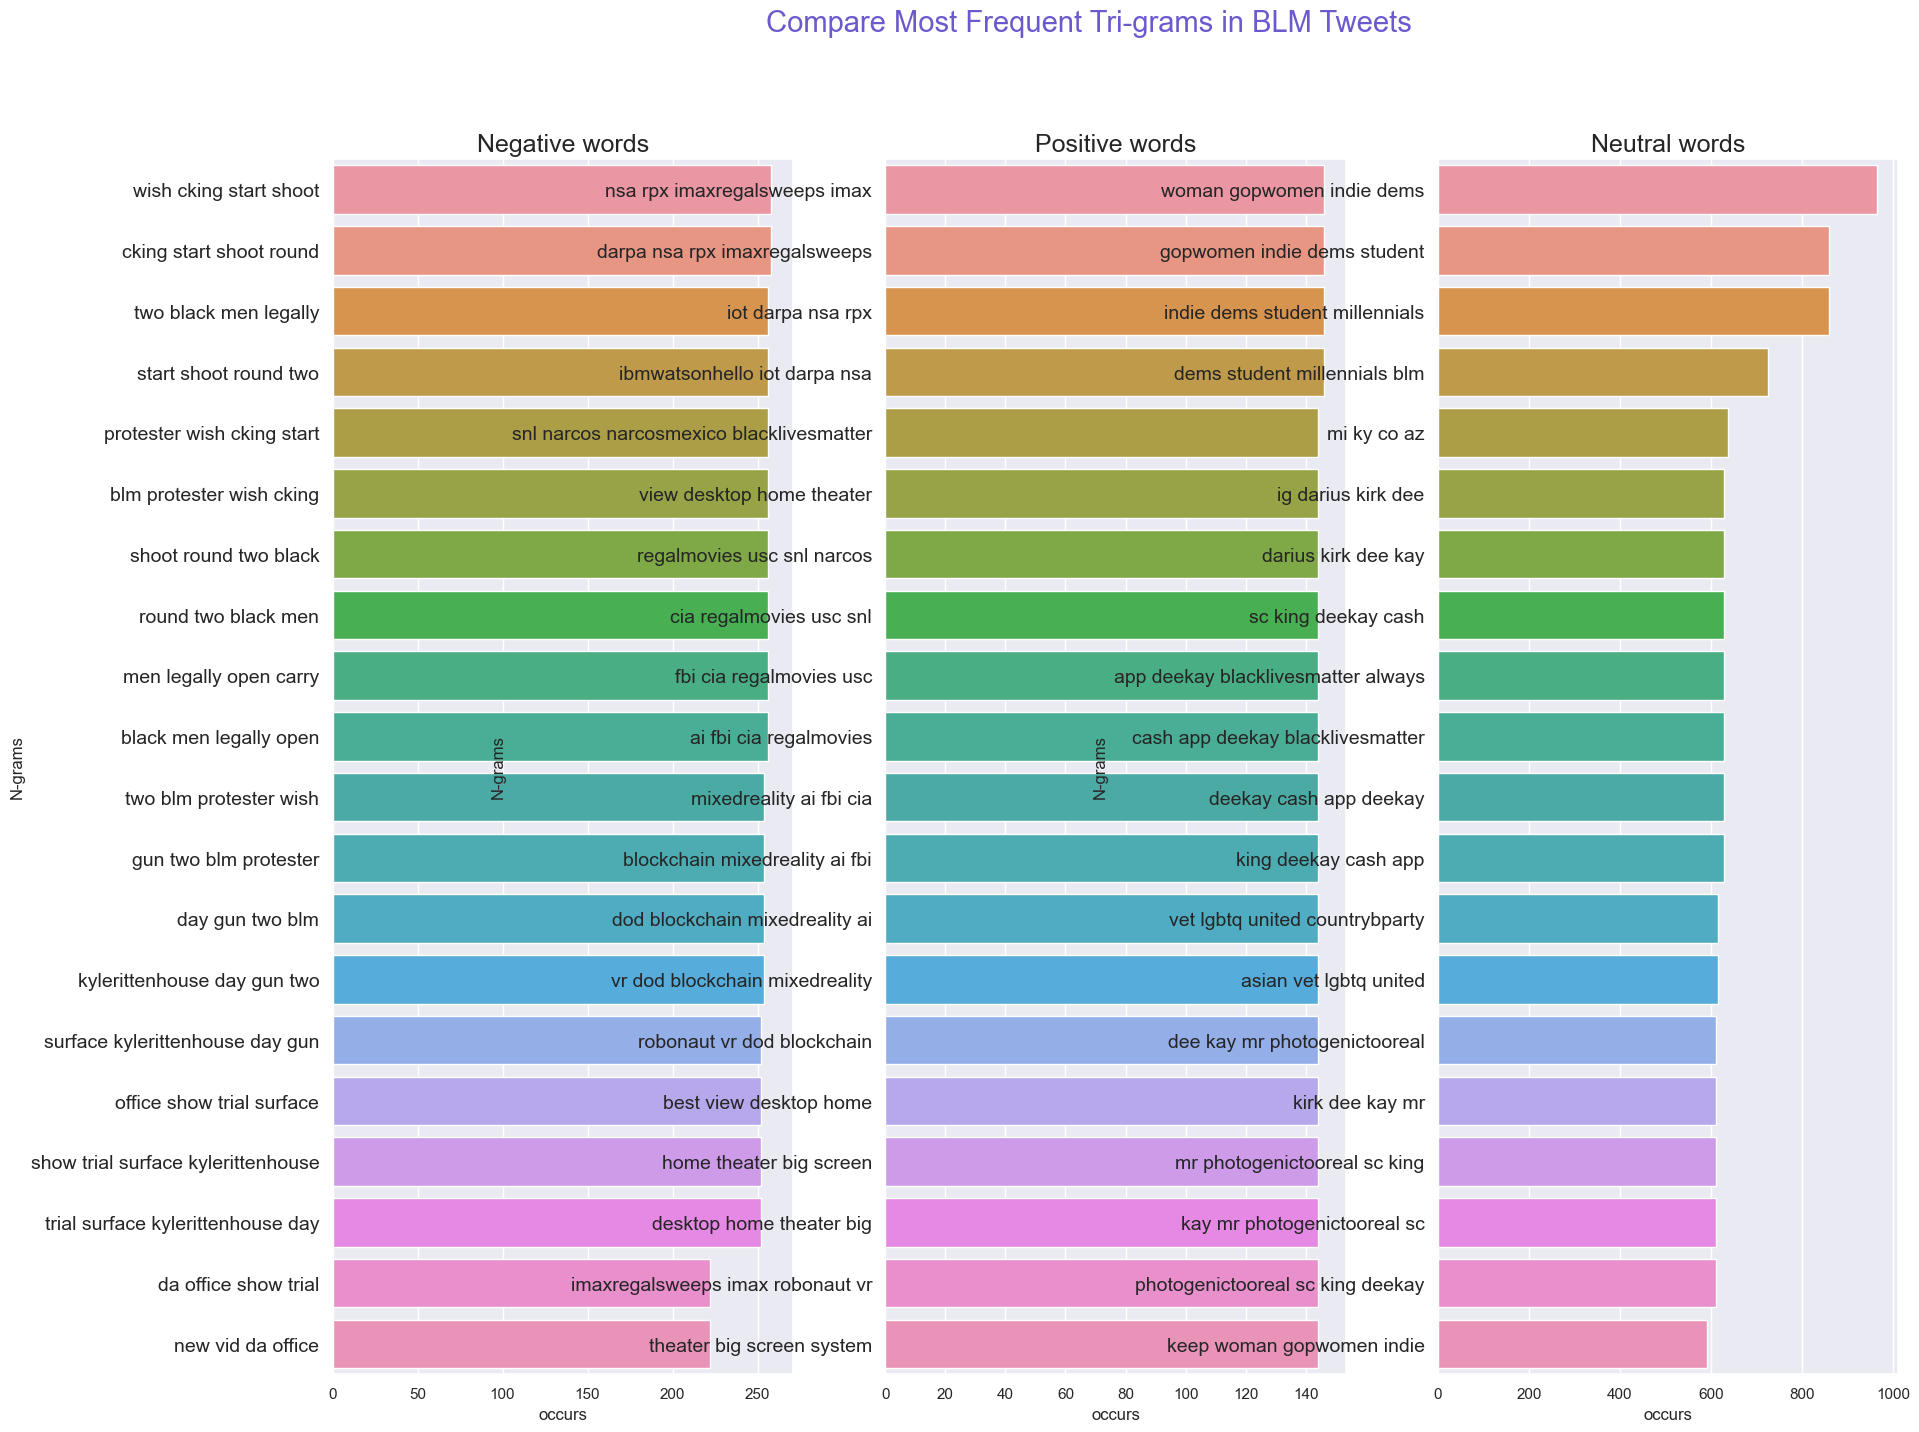

In [147]:
fig, axes = plt.subplots(1, 3)

fig.suptitle('Compare Most Frequent Quad-grams in BLM Tweets',
             size=21, color='SlateBlue')
axes[0].set_title('Negative words', size=18)
axes[1].set_title('Positive words', size=18)
axes[2].set_title('Neutral words', size=18)

plot_ngrams(ngrams_fn(df_copy, target_label='negative', n_grams=4), axes=axes[0])
plot_ngrams(ngrams_fn(df_copy, target_label='positive', n_grams=4), axes=axes[1])
plot_ngrams(ngrams_fn(df_copy, target_label='neutral', n_grams=4), axes=axes[2])
plt.show()

In [188]:
def n_grams(text, n_gram=2):
    text = text.casefold().split()
    return list(map(' '.join, zip(*[text[i:] for i in range(n_gram)])))

In [189]:
def n_gram_interpretation(n_gram):
    """
    | Created function for interpreting the `n_gram` from integer to its definition.
    Args:
        n_gram (int): number of words per sentence
    Returns:
        Text
    """
    n_gram_dict = defaultdict(lambda: 'N-grams',
                              {1: 'Uni-gram',
                               2: 'Bi-grams',
                               3: 'Tri-grams'})
    return n_gram_dict[n_gram]

In [190]:
def apply_n_gram_fn(dataframe,
                    n_gram=2):
    # initialize default dict with type `set` to remove duplicates indexes
    dicto = defaultdict(set)
    for index, tweet in dataframe['text_without_stopwords_freq'].items():
        for context in n_grams(tweet, n_gram):
            dicto[context].add(index)

    # sort the dict descending form
    dicto = {key: value for key, value in sorted(dicto.items(), key=lambda x: len(x[1]))[::-1]}
    # Convert the dict to list of tuples and 
    # switch keys & values to map it with the main dataframe
    dicto = [(value,key) for key in dicto for value in dicto[key]]
    df = pd.DataFrame(dicto)
    # Choose the most frequent N-gram and slice it from the synthetic dataframe
    df = df[~df.iloc[:,0].duplicated(keep='first')]
    # Concatenate both (Synthetic df & the original df) by indexes
    merged_df = dataframe.merge(df.iloc[:,1], how='left',
                                left_on=dataframe.index.values,
                                right_on=df.iloc[:,0])
    # Drop the key index and keep the rest
    merged_df.drop(columns='key_0', inplace=True)
    # Dealing with NaN values: 
    merged_df.fillna('IGNORE TEXT', inplace=True)
    # Rename Column
    merged_df.rename(columns={merged_df.columns[-1]:n_gram_interpretation(n_gram)}, inplace=True)
    return merged_df

In [198]:
df2 = apply_n_gram_fn(df_copy, 2)

In [199]:
df2 = apply_n_gram_fn(df2, 3)

In [192]:
bi_grams = df2['Bi-grams'].value_counts()

In [193]:
bi_grams

blm protest                4593
blm antifa                 3950
antifa blm                 3603
blm protester              2142
support blm                2100
                           ... 
mentally ill                  1
thus far                      1
either blacklivesmatter       1
immune system                 1
teach school                  1
Name: Bi-grams, Length: 6526, dtype: int64